<a href="https://colab.research.google.com/github/UpstageAI/cookbook/blob/main/Solar-Fullstack-LLM-101/82_gradio_chatpdf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 82. Gradio_chatpdf
## Overview
In this exercise, we will utilize all the RAG (Retrieval-Augmented Generation) techniques we have previously learned. We will begin by uploading a document, analyzing it, splitting it into smaller chunks, and vectorizing these chunks to store them in a vector database. When a user submits a query, the system will search the vector database for relevant information and generate real-time responses. This process will handle real-time interactions with users and create an interactive chatbot interface with search functionality.



## Purpose of the Exercise

The purpose of this exercise is to utilize all the previously learned techniques to build a comprehensive RAG system capable of processing user queries in real-time. By the end of this tutorial, users will be able to create a robust application that efficiently retrieves and responds to user queries using document-based data, enhancing the user experience with accurate and relevant information.



In [ ]:
!pip install -qU gradio python-dotenv langchain-upstage python-dotenv langchain langchain-chroma

In [2]:
# @title set API key
from pprint import pprint
import os

import warnings

warnings.filterwarnings("ignore")

if "google.colab" in str(get_ipython()):
    # Running in Google Colab. Please set the UPSTAGE_API_KEY in the Colab Secrets
    from google.colab import userdata

    os.environ["UPSTAGE_API_KEY"] = userdata.get("UPSTAGE_API_KEY")
else:
    # Running locally. Please set the UPSTAGE_API_KEY in the .env file
    from dotenv import load_dotenv

    load_dotenv()

assert (
    "UPSTAGE_API_KEY" in os.environ
), "Please set the UPSTAGE_API_KEY environment variable"

In [10]:
from langchain_upstage import (
    ChatUpstage,
    UpstageEmbeddings,
    UpstageLayoutAnalysisLoader,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser
from langchain.schema import AIMessage, HumanMessage
from langchain_text_splitters import (
    Language,
    RecursiveCharacterTextSplitter,
)
from langchain_chroma import Chroma

llm = ChatUpstage(model="solar-pro", streaming=True)

In [11]:
# More general chat
chat_with_history_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant.\nContext: {context}"),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{message}"),
    ]
)

In [12]:
chain = chat_with_history_prompt | llm | StrOutputParser()

In [13]:
text_splitter = RecursiveCharacterTextSplitter.from_language(
    chunk_size=1000, chunk_overlap=100, language=Language.HTML
)

In [14]:
def chat(message, history, retriever):
    result_docs = ""
    if retriever:
        result_docs = retriever.invoke(message)

    history_langchain_format = []
    for human, ai in history:
        history_langchain_format.append(HumanMessage(content=human))
        history_langchain_format.append(AIMessage(content=ai))

    generator = chain.stream(
        {
            "context": result_docs,
            "message": message,
            "history": history_langchain_format,
        }
    )

    assistant = ""
    for gen in generator:
        assistant += gen
        yield assistant

In [15]:
def file_upload(file):
    layzer = UpstageLayoutAnalysisLoader(file, output_type="html", use_ocr=False)
    docs = layzer.load()
    splits = text_splitter.split_documents(docs)
    print(len(splits))
    vectorstore = Chroma.from_documents(
        documents=splits,
        embedding=UpstageEmbeddings(
            model="solar-embedding-1-large", embed_batch_size=100
        ),
    )
    retriever = vectorstore.as_retriever()

    return file, retriever

In [16]:
import gradio as gr

with gr.Blocks() as demo:
    gr.Markdown("# Solar Chatbot")
    gr.Markdown(
        "Upstage Solar Chatbot",
    )
    with gr.Row():
        with gr.Column():
            file = gr.File()
            retreiver = gr.State()
        with gr.Column():
            chatbot = gr.ChatInterface(
                chat,
                examples=[
                    ["How to eat healthy?"],
                    ["Best Places in Korea"],
                    ["How to make a chatbot?"],
                ],
                additional_inputs=retreiver,
            )
    chatbot.chatbot.height = 300
    file.upload(file_upload, file, [file, retreiver])

In [17]:

if __name__ == "__main__":
    demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://e0236f979583f8e11a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Example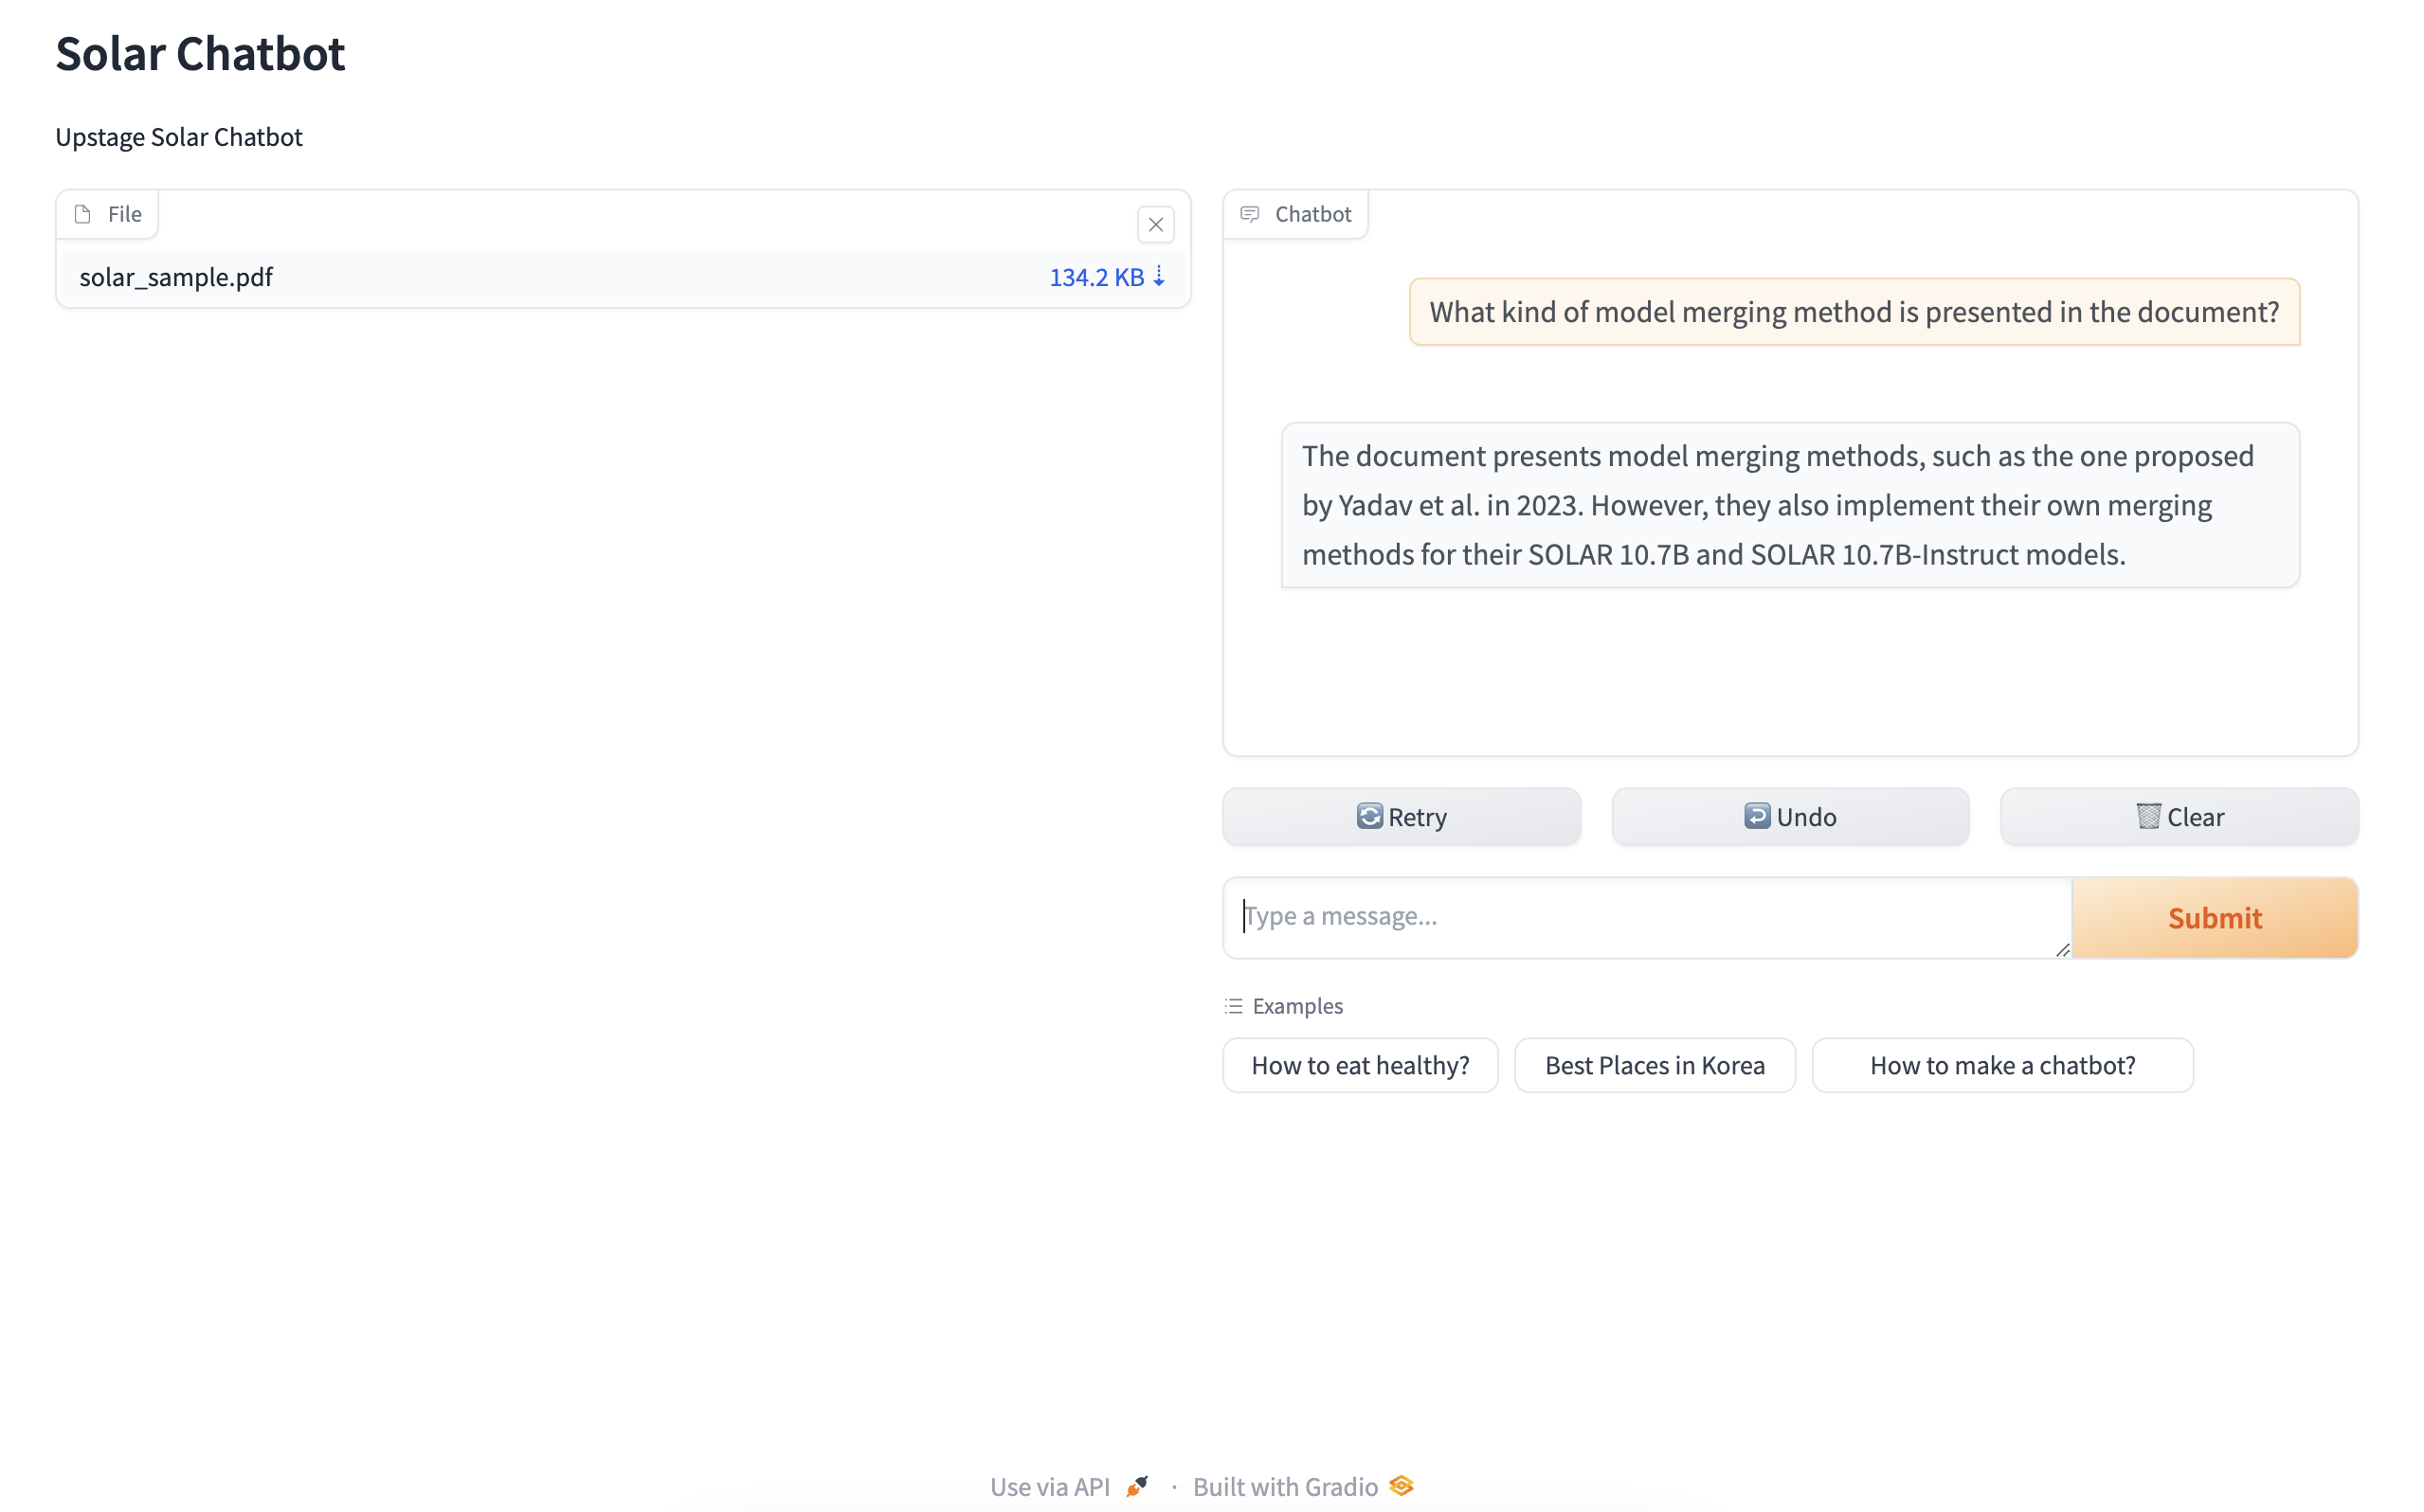